In [1]:
import numpy as np
import pandas as pd
from Bio import Phylo
from cStringIO import StringIO
import matplotlib
import matplotlib.pyplot as plt

In [2]:
path = './series2/mage_1/mut-whole-mstd_1.00-mage_1.csv'

pop = pd.read_csv(path)
pop.parent_id[pop.parent_id < 0] = np.nan
n_ages = pop.age.unique().size

/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Build phylogeny tree in Newick format from population dataframe

In [3]:
def id_to_newick_dist(p_data,p,root,stop_nodes=[]):
    items = []
    
    root_data = p_data[p_data.id==root][:n_ages]
    root_d = root_data.death.values
    root_b = root_data.reproduction.values
    
    for node in p[np.logical_and(p.parent_id==root, p.id!=root)].id.values:
        s = ''
        if p[np.logical_and(p.parent_id==node, p.id!=node)].id.values.size > 0 and node not in stop_nodes:
            sub_tree = id_to_newick_dist(p_data,p,node)
            if sub_tree != '':
                s += '(' + sub_tree + ')'
        
        node_data = p_data[p_data.id==node][:n_ages]
        node_d = node_data.death.values
        node_b = node_data.reproduction.values
        distance = np.sum(root_d != node_d) + np.sum(root_b != node_b)
        #print node,': ',distance
        
        s += str(node) + ':' + str(distance)
        #print s
        items.append(s)
    return ','.join(items)

In [4]:
def id_to_newick(p,root,stop_nodes=[]):
    items = []
    
    for node in p[np.logical_and(p.parent_id==root, p.id!=root)].id.values:
        s = ''
        if p[np.logical_and(p.parent_id==node, p.id!=node)].id.values.size > 0 and node not in stop_nodes:
            sub_tree = id_to_newick(p,node)
            if sub_tree != '':
                s += '(' + sub_tree + ')'
        
        s += str(node)
        items.append(s)
    return ','.join(items)

In [54]:
def find_parent(p, _id):
    if id==0: return np.nan
    return p[p.id==_id].parent_id.unique()[0]

# Find most frequent IDs among living

In [72]:
#def find_cut(arr, eps):
#    delta = arr[:-1] - arr[1:]
#    return np.argmax(delta<eps)

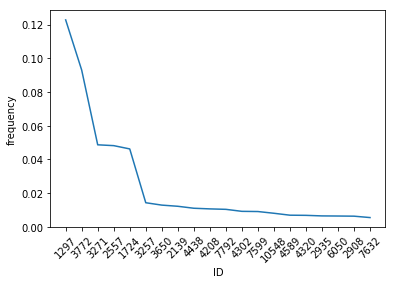

In [5]:
p = pop[pop.alive == 1]
u,c = np.unique(p.id, return_counts=True)
sort_ix = np.argsort(c)[::-1] # ascending

how_many = 20

xlabel = u[sort_ix]
y = (c[sort_ix]/float(np.sum(c)))[:how_many]
plt.plot(y)
plt.xticks(np.arange(how_many), xlabel[:how_many], rotation=45)
plt.xlabel('ID')
plt.ylabel('frequency')
plt.show()

#ten_most = u[sort_ix][:10] # ten most numerous IDs
#p_ten_most = p[p.id.isin(ten_most)]
#print ten_most
#print np.around(c[sort_ix][:10]/float(p.id.size),4)

# Phylogeny analysis attempt

In [6]:
import time
start = time.time()

root = 0
# this might take a while
#tree = Phylo.read(StringIO('('+id_to_newick(pop[pop.age==0],root)+')' + str(root)),'newick')
tree = Phylo.read(StringIO('('+id_to_newick_dist(pop,pop[pop.age==0],root)+')'+str(root)),'newick')

print (time.time() - start) / 60
#mrca = tree.common_ancestor('343','211')
#print mrca

20.6342417161


In [7]:
import copy
tree_sc = copy.deepcopy(tree)

In [8]:
tree = copy.deepcopy(tree_sc)

In [9]:
for clade in tree.find_clades():
    if not clade.name:
        clade.name = str(clade.confidence)

In [10]:
living = pop[np.logical_and(pop.age==0, pop.alive==1)].id.unique().astype(str)
print len(living)

2464


In [15]:
mrca = tree.common_ancestor(u[sort_ix][:1].astype(str))
#mrca = tree.common_ancestor(living.astype(str))
print mrca

1297


In [283]:
for clade in tree.find_clades():
    if not clade.name:
        clade.name = str(clade.confidence)

In [275]:
print pop[pop.id == 1187].birth_date.min()

6.002567544890784


In [284]:
def keep_living(tree, living):
    leaves = tree.get_terminals()
    ids = []
    for i in leaves: ids.append(i.name)
    while not set(ids).issubset(set(living)) > 0:
        print len(leaves)
        for leaf in leaves:
            if not leaf.name in living:
                tree.prune(leaf)
        leaves = tree.get_terminals()
        ids = []
        for i in leaves: ids.append(i.name)

In [285]:
keep_living(tree, pop[np.logical_and(pop.age==0, pop.alive==1)].id.unique().astype(str))
#tree.prune(tree.get_terminals()[0])

9181
1557
1146
1119
1119


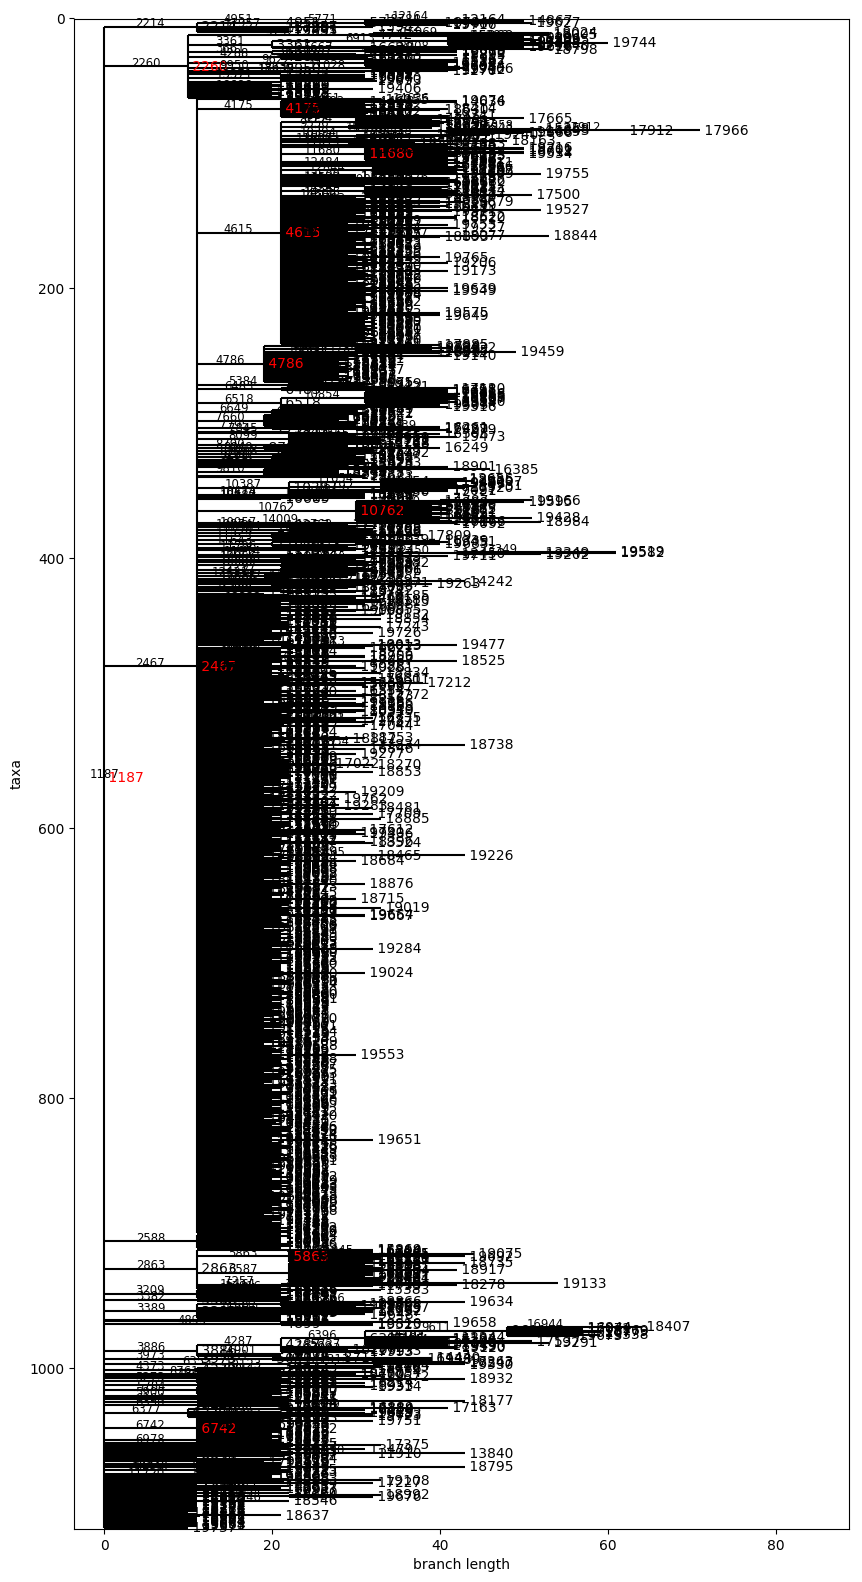

In [286]:
#tree.ladderize()
matplotlib.rc('font', size=10)
fig = plt.figure(figsize=(10,20), dpi=100)
axes = fig.add_subplot(1,1,1)
Phylo.draw(tree, axes=axes, label_colors={k:'red' for k in ten_most.astype(str)})
plt.show()